In [1]:
import numpy as np
from scipy import signal
from scipy.signal import hilbert, welch, butter, freqz, lfilter, correlate, correlation_lags, find_peaks
from scipy.fft import fft, fftfreq, irfft
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
image_path = "./drop-250925-4/170.jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

h, w = img.shape
y_centr = h//2

print(h, w)

294 272


In [3]:
%load_ext autoreload
%autoreload 2
    
from generate_areas import img_bunch_gen


In [27]:
dx0_lim = np.array((-0.5, 1))
xl = 121
print(np.random.randint(*(dx0_lim*xl),10))

[ 79 102  64  39  59  78 -48 -45 -20 -55]


In [34]:
img_bunch_gen(image_path, N=300, dx0_lim = 0, dy0_lim = 0, dxl_lim = (-0.5, 0.5), dyl_lim = 0)

In [6]:
## To get rid of all meaningless spectral components, we need bandpass filter

# butterworth bandpass filtr creation
def my_butter(fq0, fs=0.5, peak_count=3, N=4):

    if peak_count == 0:
        peak_count = 1
    Wn = [fq0*(peak_count), min(fq0*(peak_count)*2, fs/2.01)]
    #print(Wn)
    btype = 'bandpass'

    b, a  = butter(N, Wn, btype, fs = fs)
    return b, a
    
# butterworth highpass filtr creation
# to cut off low frequences for better peak count
def my_butter_high(fq0, nl = 3, fs=0.5, N=4):
    f_cut = min(fq0*nl, fs/2.01)
    #print(f_cut)
    btype = 'highpass'

    b, a = butter(N, f_cut, btype, fs=fs)
    return b, a


def phase_vel(ins_ph, dt):
    return np.mean(np.diff(ins_ph)/dt/2/np.pi)

def auto_corr(signal, sig_point_num):
    # signal - signal to find autocorrelation of
    # sig_point_num - number of data points in signal
    
    sig_cor = correlate(signal, signal, mode = 'same')
    sig_cor_lag = correlation_lags(sig_point_num, sig_point_num,  mode = 'same')

    return sig_cor_lag[sig_point_num//2:], sig_cor[sig_point_num//2:]/np.max(sig_cor)

def peak_counter(signal):
    # returns number of peaks in a signal and mean period
    peaks, _ = find_peaks(signal)
    peak_count = len(peaks)
    mean_period = np.mean(np.diff(peaks))
    
    return peak_count, mean_period

In [40]:
def analize_signal(sig, dt):
    # sig - original signal
    # dt - discritization step
    sig_len = len(sig)
    fs = 0.5/dt
    f0 = 1/sig_len

    # pass the signal through highpass filter to get rid of low frequences
    bh, ah = my_butter_high(fq0 = f0, nl=1, fs=fs)
    sig_flt_h = lfilter(bh, ah, sig)

    # compute autocorrelation dencity function
    _, sig_cor = auto_corr(sig_flt_h, sig_len)

    # count the number of times correlation function has maximum - number of 
    # periods in the picture
    # we will assume (so far) that the peaks are distributed evenly
    peaks, _ = find_peaks(sig_cor)
    peak_count = len(peaks)

    # use the bandpath butter filter with the number of peaks we found as parameter
    b, h = my_butter(fq0 = f0, fs=fs, peak_count=peak_count)
    sig_flt = lfilter(b, h, sig)

    # restore analitical signal from filtered signal
    # find instant phase and from it - phase velocity
    anal_y = hilbert(np.real(sig_flt))
    instant_phase = np.unwrap(np.angle(anal_y))
    ph_vel = phase_vel(instant_phase, dt)

    return peak_count, ph_vel

In [41]:
path_img = "./averaged_imgs.txt"

with open(path_img, 'r') as f:
    data_img = json.load(f)

#data_img = [*zip(*list_img)]

imgs = data_img[4]
x0_shift = np.array(data_img[0]) - data_img[0][0]
y0_shift = np.array(data_img[1]) - y_centr
width = np.array(data_img[2])
hight = np.array(data_img[3])

ph_vel_list = []
peak_count = []

for img in imgs:
    n, pv = analize_signal(img, dt=1)
    ph_vel_list.append(pv)
    peak_count.append(n)

phv_mean = np.mean(ph_vel_list)
phv_std = np.std(ph_vel_list)

print(f" mean phase velocity: {phv_mean} \n standart deviation: {phv_std} \n std in percentage: {phv_std/phv_mean*100}%")

 mean phase velocity: 0.22649608194258505 
 standart deviation: 0.01318815209742817 
 std in percentage: 5.822684429822172%


In [17]:
import pandas as pd

In [42]:
img_stats = np.array([ph_vel_list, peak_count, width, hight, x0_shift, y0_shift])

df = pd.DataFrame(img_stats.T, columns=['ph_vl', 'n', 'w', 'h', 'dx0', 'dy0'])
df.head(10)

,ph_vl,n,w,h,dx0,dy0
0,0.210830,3.0,38.0,4.0,0.0,3.0
1,0.225281,2.0,22.0,4.0,0.0,3.0
2,0.237842,4.0,46.0,4.0,0.0,3.0
3,0.230486,2.0,26.0,4.0,0.0,3.0
4,0.193698,1.0,19.0,4.0,0.0,3.0
5,0.225281,2.0,22.0,4.0,0.0,3.0
6,0.244394,5.0,53.0,4.0,0.0,3.0
7,0.220749,3.0,32.0,4.0,0.0,3.0
8,0.240791,2.0,21.0,4.0,0.0,3.0
9,0.235171,5.0,56.0,4.0,0.0,3.0


In [30]:
len(df['n'])

301

In [43]:
df_n = df.groupby(by=['n']).mean()
df_n

,ph_vl,w,h,dx0,dy0
n,,,,,
1.0,0.192095,19.368421,4.0,0.0,3.0
2.0,0.225165,24.776119,4.0,0.0,3.0
3.0,0.221673,33.530120,4.0,0.0,3.0
4.0,0.231401,43.151899,4.0,0.0,3.0
5.0,0.240753,52.433962,4.0,0.0,3.0


In [44]:
df_n['w']/df_n.index

n
1.0    19.368421
2.0    12.388060
3.0    11.176707
4.0    10.787975
5.0    10.486792
dtype: float64

In [28]:
from matplotlib import pyplot as plt

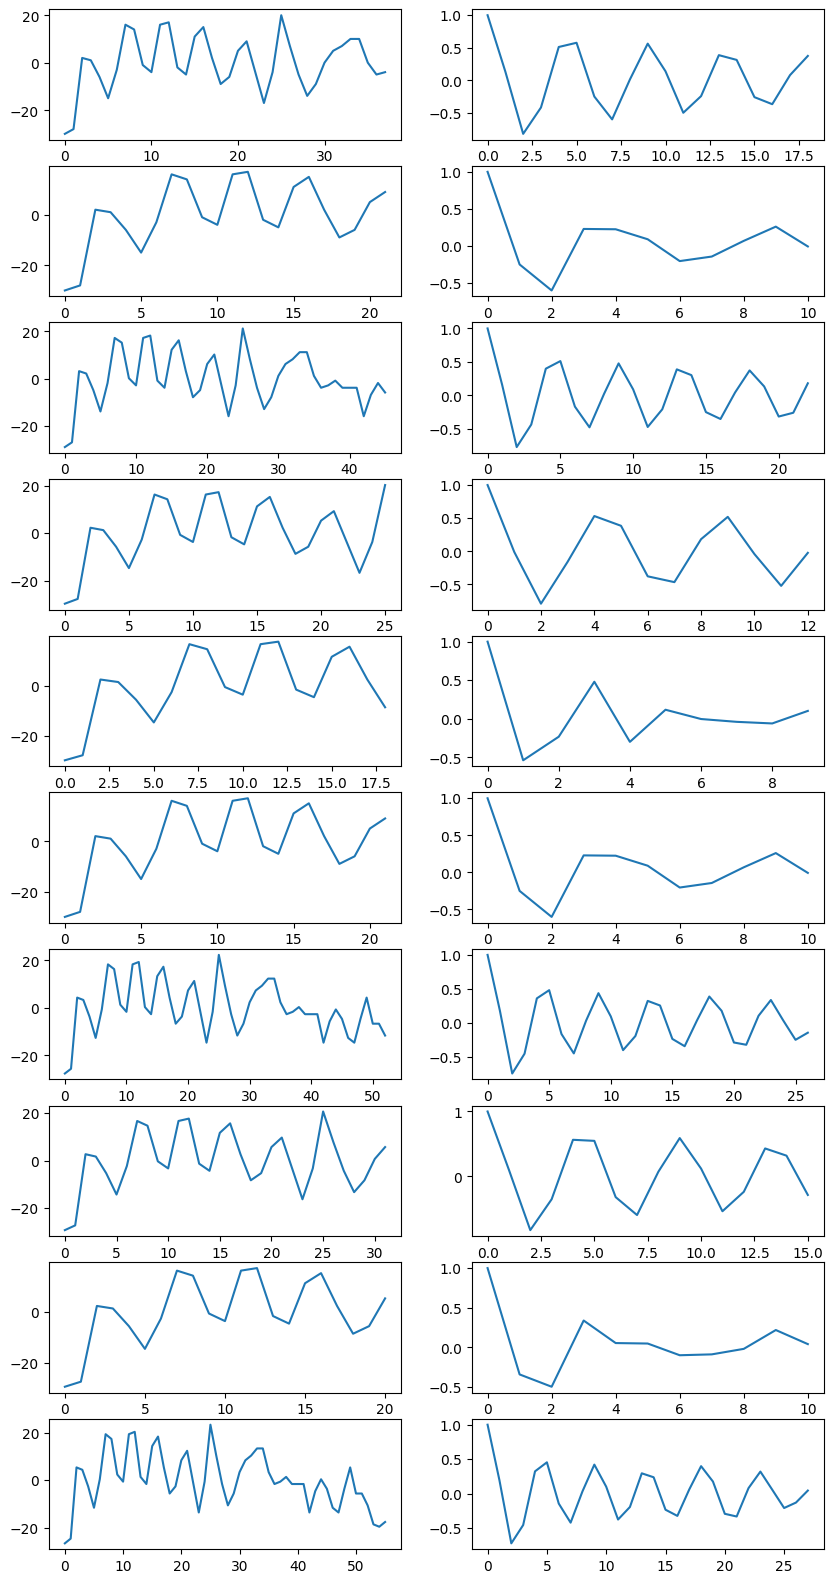

In [45]:
N = 10
fig, ax = plt.subplots(N, 2, figsize=(10,20))

for i in range(N):
    sig = imgs[i]
    ax[i][0].plot(sig)
    
    sig_len = len(sig)
    f0 = 1/sig_len
    fs=0.5
    bh, ah = my_butter_high(fq0 = f0, fs=fs)
    sig_flt_h = lfilter(bh, ah, sig)
    
    ax[i][1].plot(*auto_corr(sig_flt_h, sig_len))

In [15]:
list1 = [1,2,3,4,5]
a = [0]
print(list1+a)

[1, 2, 3, 4, 5, 0]
